In [0]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import *
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D, Lambda
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion
color = sns.color_palette()
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
np.random.seed(111)
aug.seed(111)

In [0]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 1741 (delta 69), reused 84 (delta 55), pack-reused 1616
Receiving objects: 100% (1741/1741), 221.08 MiB | 36.15 MiB/s, done.
Resolving deltas: 100% (843/843), done.
Checking out files: 100% (357/357), done.


In [0]:
data = pd.read_csv("covid-chestxray-dataset/metadata.csv")
data.describe(include='all') 

,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 27
count,360.000000,264.000000,317,306.000000,360,109,72,65,28,12,16,33.000000,41.000000,11.000000,2.000000,9.000000,360,360,291,242,360,360,104,360,197,350,222,4
unique,NaN,NaN,2,NaN,11,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,7,2,63,52,2,360,32,173,7,275,97,3
top,NaN,NaN,M,NaN,COVID-19,Y,Y,Y,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,PA,X-ray,2020,Italy,images,SARS-10.1148rg.242035193-g04mr34g07b-Fig7b-day...,10.1148/rg.242035193,https://pubs.rsna.org/doi/10.1148/rg.242035193,CC BY-NC-SA,Small consolidation in right upper lobe and gr...,"Credit to Omir Antunes Paiva, Dr. Rodrigo Caru...","Case courtesy of Dr Edgar Lorente, Radiopaedia..."
freq,NaN,NaN,200,NaN,284,82,62,35,25,7,8,NaN,NaN,NaN,NaN,NaN,194,316,149,63,339,1,11,11,140,5,10,2
mean,96.916667,6.477273,NaN,55.826797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.903030,87.982927,5.454545,3.590000,0.962222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,60.098005,7.025717,NaN,15.834784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.924511,11.327928,2.954828,2.771859,0.375326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.000000,-5.000000,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.400000,50.000000,0.220000,1.630000,0.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,39.750000,2.000000,NaN,45.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.800000,85.000000,3.140000,2.610000,0.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,94.500000,5.000000,NaN,58.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.000000,92.000000,6.370000,3.590000,0.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,150.250000,9.000000,NaN,70.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.000000,96.000000,6.875000,4.570000,1.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
data['finding'].value_counts()

COVID-19          284
Streptococcus      17
SARS               16
Pneumocystis       15
COVID-19, ARDS     12
E.Coli              4
ARDS                4
No Finding          3
Legionella          2
Chlamydophila       2
Klebsiella          1
Name: finding, dtype: int64

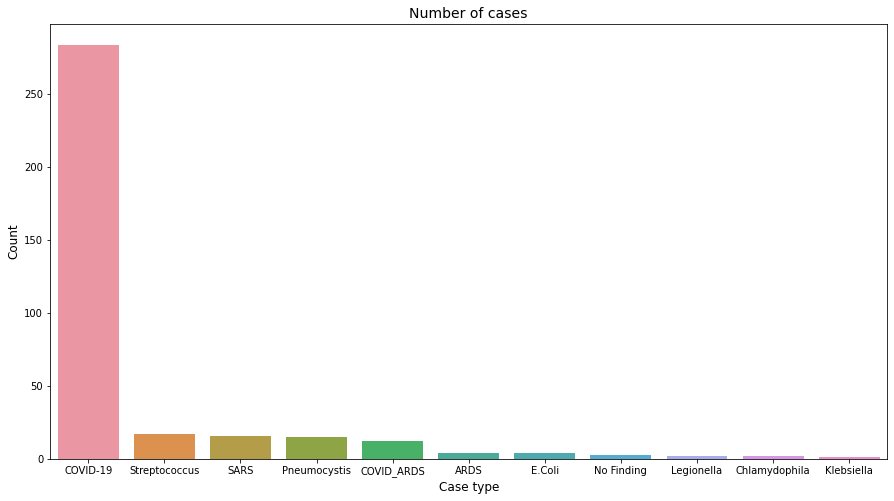

In [0]:
cases_count = data['finding'].value_counts()

plt.figure(figsize=(15,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['COVID-19','Streptococcus','SARS','Pneumocystis','COVID_ARDS','ARDS','E.Coli','No Finding','Legionella','Chlamydophila','Klebsiella'])
plt.show()

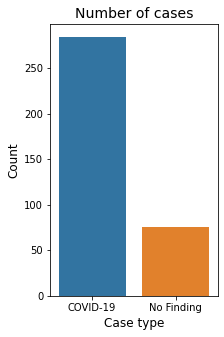

In [0]:
cases_count = data['finding'].value_counts()
index = ['COVID-19','No Finding']
value = [284,76]
plt.figure(figsize=(3,5))
sns.barplot(x=index, y= value)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
# plt.xticks(range(len(cases_count.index), ['COVID-19','No Finding']))
plt.show()

In [0]:
def get_label(imgs):
  for index, row in data.iterrows():
    if str(imgs) == str(row['filename']):
      if str(row['finding']) == 'COVID-19':
        return 1
      else:
        return 0

In [0]:
data_dir = Path('covid-chestxray-dataset/images/')
IMG_SIZE = 150

train_data = []
output = []
count_0 = 0
count_1 = 0
for img in tqdm(os.listdir(data_dir)):
  label= get_label(img)
 
  if label is not None:
    if label == 0:
      if count_0 < 70:
        path = os.path.join(data_dir,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        img = img.astype('float32')
        img /= 255
        train_data.append(np.array(img).reshape((IMG_SIZE,IMG_SIZE,1)))
        output.append(np.array(label))
      count_0 += 1
    elif label == 1:
      if count_1 < 70:
        path = os.path.join(data_dir,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        img = img.astype('float32')
        img /= 255
        train_data.append(np.array(img).reshape((IMG_SIZE,IMG_SIZE,1)))
        output.append(np.array(label))
        
       
      count_1 += 1

train_data = np.array(train_data)
output = np.array(output)
shuffle(train_data)
np.save('train_data.npy', train_data)

100%|██████████| 343/343 [00:11<00:00, 28.65it/s]


In [0]:
print(train_data.shape)

(140, 150, 150, 1)


In [0]:
print(output.shape)

(140,)


In [0]:
series_new = []
output_new = []

for i in range(output.shape[0]):
  if output[i] == 0:
    series_new += [train_data[i]]
    output_new += [output[i]]

  elif output[i] == 1:
    series_new += [train_data[i]]
    output_new += [output[i]]


series_new = np.array(series_new)
output_new = np.array(output_new)

print(series_new.shape)
print(output_new.shape)

(140, 150, 150, 1)
(140,)


In [0]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [0]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [0]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [0]:
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [0]:
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [0]:
def get_data(data, output, name):
  pair_0 = []
  pair_1 = []

  for i in range(len(output)):
    if int(output[i]) == 0:
      pair_0.append(data[i])
    else:
      pair_1.append(data[i])

  pair_0 = np.array(pair_0)
  pair_1 = np.array(pair_1)

  print(name + ": The length of the pair_0 is " + str(pair_0.shape))
  print(name + ": The length of the pair_1 is " + str(pair_1.shape))
  
  return pair_0, pair_1

In [0]:
def process_data():

  pair_all_0, pair_all_1 = get_data(series_new, output_new, "All pairs",)

  combined_pairs = compine_negative_positive_pair(pair_all_0,pair_all_1,  "All pairs")

  return (combined_pairs)

In [0]:
def create_positive_pair(pair_0,pair_1, name):
  input_data_positive = []
  i = 0
  count_0 = len(pair_0)
  count_1 = len(pair_1)
  threshold = count_0 * count_1 / 2

  for Pair_0 in pair_0:
    if i < threshold:
      for Pair_1 in pair_0:
        input_data_positive += [[np.array(Pair_0),np.array(Pair_1),1]]
        i += 1

  for Pair_0 in pair_1:
    if i < count_0 * count_1:
      for Pair_1 in pair_1:
        input_data_positive += [[np.array(Pair_0),np.array(Pair_1),1]]
        i += 1

  input_data_positive = np.array(input_data_positive)
  print(name + ": The length of the Positive Samples is " + str(input_data_positive.shape))
  
  return input_data_positive

In [0]:
def create_negative_pair(pair_0,pair_1, name):
  input_data_negative = []
  for Pair_0 in pair_0:
    for Pair_1 in pair_1:
      input_data_negative += [[np.array(Pair_0),np.array(Pair_1),0]]

  input_data_negative = np.array(input_data_negative)
  print(name + ": The length of the Negative Samples is " + str(input_data_negative.shape))
  
  return input_data_negative

In [0]:
def compine_negative_positive_pair(pair_0,pair_1, name):
  input_data_negative = create_negative_pair(pair_0,pair_1, name)
  input_data_positive = create_positive_pair(pair_0,pair_1, name)
  input_array_final = []
  count_negative = 0
  count_positive = 0

  while count_negative < len(input_data_negative) and count_positive < len(input_data_positive):
    n = random.randint(0, 1)

    if count_positive == len(input_data_positive):
      n = 0

    if count_negative == len(input_data_negative):
      n = 1

    if n == 0 and count_negative < len(input_data_negative):
      input_array_final += [input_data_negative[count_negative]]
      count_negative += 1
    elif n == 1 and count_positive < len(input_data_positive):
      input_array_final += [input_data_positive[count_positive]]
      count_positive += 1

  input_array_final = np.array(input_array_final)
  print(name + ": The length of All Samples is " + str(input_array_final.shape))
  
  return input_array_final

In [0]:
import random as random

all_pairs = process_data()
slicing = int(0.7 * len(all_pairs))

training_pairs = all_pairs[0:slicing,:]
testing_pairs = all_pairs[slicing:-1,:]

training_output = training_pairs[:,2]
testing_output = testing_pairs[:,2]

training_pairs = np.delete(training_pairs,2,1)
testing_pairs = np.delete(testing_pairs,2,1)

training_sets = []
testing_sets = []

for i in range(len(training_pairs)):
  training_sets += [[training_pairs[i][0], training_pairs[i][1]]]

for i in range(len(testing_pairs)):
  testing_sets += [[testing_pairs[i][0], testing_pairs[i][1]]]

training_sets = np.array(training_sets)
testing_sets = np.array(testing_sets)

validation_size = int(0.7 * testing_sets.shape[0])

validation_sets = testing_sets[validation_size:-1]
testing_sets = testing_sets[0:validation_size]

validation_output = testing_output[validation_size:-1]
testing_output = testing_output[0:validation_size]

input_shape = (IMG_SIZE,IMG_SIZE,1)
print(f'input_shape is {input_shape}')

print(f'training  sets shape is {training_sets.shape}')
print(f'validation sets shape is {validation_sets.shape}')
print(f'testing sets shape is {testing_sets.shape}')

All pairs: The length of the pair_0 is (70, 150, 150, 1)
All pairs: The length of the pair_1 is (70, 150, 150, 1)
All pairs: The length of the Negative Samples is (4900, 3)
All pairs: The length of the Positive Samples is (4900, 3)
All pairs: The length of All Samples is (9747, 3)
input_shape is (150, 150, 1)
training  sets shape is (6822, 2, 150, 150, 1)
validation sets shape is (877, 2, 150, 150, 1)
testing sets shape is (2046, 2, 150, 150, 1)


In [0]:
def build_model():
    input_img = Input(shape=(IMG_SIZE,IMG_SIZE,1), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(512, activation='relu', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [0]:
base_network = build_model()

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)
opt = Adam(lr=0.0001, decay=1e-6)

rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=opt, metrics=[accuracy])
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, verbose=1, mode='auto',restore_best_weights=True)

In [0]:
epochs = 100
history = model.fit([training_sets[:,0][:], training_sets[:,1][:]], training_output,
          batch_size=16,
          epochs=epochs,
          validation_data=([validation_sets[:, 0], validation_sets[:, 1]], validation_output),
          callbacks=[earlyStopping]
          )

In [0]:
# # compute final accuracy on training and test sets
y_pred = model.predict([training_sets[:, 0], training_sets[:, 1]])
tr_acc = compute_accuracy(training_output, y_pred)
y_pred = model.predict([testing_sets[:, 0], testing_sets[:, 1]])

te_acc = compute_accuracy(testing_output, y_pred)
print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 63.14%
* Accuracy on test set: 67.04%


In [0]:
print(np.argmax(y_pred))

148


In [0]:
# pred = np.around(y_pred).astype('int32').reshape(size)
pred = y_pred.ravel() < 0.5
true = testing_output.astype('int32').reshape(size)
for i in range(pred.shape[0]):
  if pred[i] == true[i]:
    print(i)

# print(pred[148])

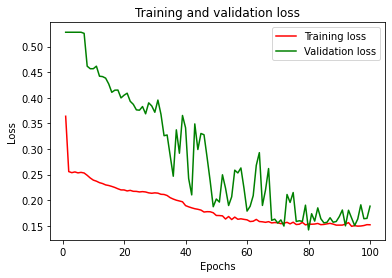

In [0]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

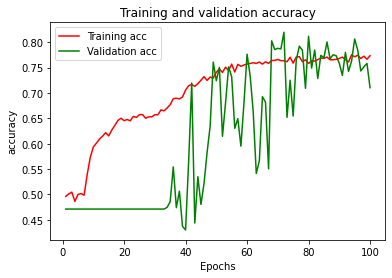

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import classification_report
size = testing_output.shape[0]
pred = y_pred.ravel() < 0.5
true = testing_output.astype('int32').reshape(size)
print(classification_report(true, pred))

              precision    recall  f1-score   support

           0       0.72      0.52      0.60       983
           1       0.65      0.81      0.72      1065

    accuracy                           0.67      2048
   macro avg       0.68      0.66      0.66      2048
weighted avg       0.68      0.67      0.66      2048



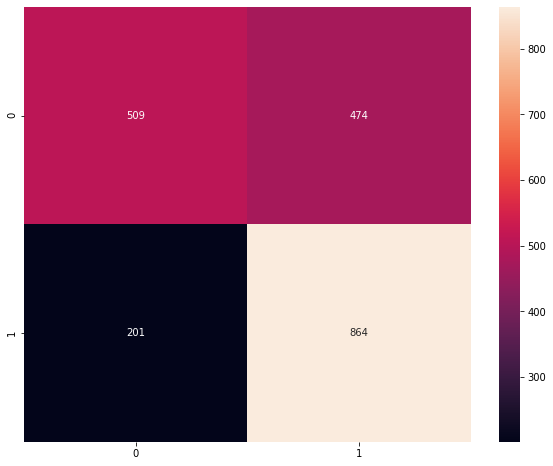

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

size = testing_output.shape[0]
pred = y_pred.ravel() < 0.5
true = testing_output.astype('int32').reshape(size)

confusion_mtx = confusion_matrix(true,pred) 

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d");

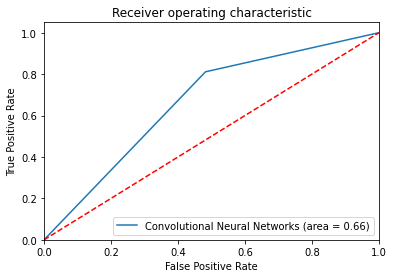

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

size = testing_output.shape[0]
pred = y_pred.ravel() < 0.5
true = testing_output.astype('int32').reshape(size)

logit_roc_auc = roc_auc_score(true, pred)
fpr, tpr, thresholds = roc_curve(true, pred)
plt.figure()
plt.plot(fpr, tpr, label='Convolutional Neural Networks (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [0]:
!pip install h5py

In [0]:
from keras.models import model_from_json

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")


Saved model to disk


In [0]:
# !pip install pydot-ng

In [0]:
# !pip install graphviz

In [0]:
from keras.utils.vis_utils import plot_model
model_graph = build_model()
graph = plot_model(model, to_file='my_model.png', show_shapes=True)